## Take vsearch sintax output and plot taxonomic assignment confidence levels

### Extracted SSU rRNA reads were run against a sintax-formatted SILVA 138.1 database using vsearch v?? with the following command: 
vsearch --sintax {sample}-16S-18S-hmm-hits.fa --db SILVA138_RESCRIPt.fasta.gz --tabbedout {sample}-16S-18S-sintax.out.tsv

### SSU rRNA reads were generated from (a) PhyloFlash on unassembled Illumina reads, (b) Illumina-SPAdes, PacBio-metaFlye, and Illumina-PacBio-hybridSPAdes contigs run against HMMs in anvi'o. For (b) the 16S and 18S rRNA output fasta files were concatenated.

In [1]:
import pandas as pd
import os as os
import glob as glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/Lasker 2019/PacBio/assembly-comparisons/vsearch-confidence")

### Open example file

In [3]:
vs = pd.read_csv("metaflye-16S-18S-hmms-sintax-SILVA.out.tsv", sep=" |\t", header=None, names=['query', 'hit','strand'],
                engine='python')
vs.head()

,query,hit,strand
16S_rRNA_bac___Ribosomal_RNA_16S___c8ad297990e3ced4cfa6c4eaf5e4bbd31d0f80d8360a83596ba3a085,bin_id:1903c117_50m-3_assembly-contigs|source:...,"d:Bacteria(1.00),p:Proteobacteria(1.00),c:Alph...",+
16S_rRNA_bac___Ribosomal_RNA_16S___f6f1cefb4860f9446c703dbd5452c98ecdb5c57359f05416db703cc7,bin_id:1903c117_50m-3_assembly-contigs|source:...,"d:Bacteria(1.00),p:Proteobacteria(1.00),c:Alph...",+
18S_rRNA_euk___Ribosomal_RNA_18S___a4c3c81f0afb9174a70c7a4410cc0d157de905313b773c3041b2438d,bin_id:1903c117_50m-3_assembly-contigs|source:...,None,None
16S_rRNA_arc___Ribosomal_RNA_16S___b29d8740233e5d5d083fd1edf91de95b34570aaa59d7cb24c3e9ab44,bin_id:1903c117_50m-3_assembly-contigs|source:...,"d:Archaea(1.00),p:Thermoplasmatota(1.00),c:The...",+
16S_rRNA_arc___Ribosomal_RNA_16S___1649bc254ae80952bd8ff441850d4f121f65dde334e466c0c3477853,bin_id:1903c117_50m-3_assembly-contigs|source:...,"d:Bacteria(1.00),p:Planctomycetota(1.00),c:Pla...",+


In [4]:
taxa = vs[['query','hit']].copy()
taxa = taxa.set_index('query')
taxa.head()

,hit
query,
bin_id:1903c117_50m-3_assembly-contigs|source:Ribosomal_RNA_16S|e_value:1e-254|contig:c_000000017069|gene_callers_id:128043|start:3820|stop:5320|length:1500,"d:Bacteria(1.00),p:Proteobacteria(1.00),c:Alph..."
bin_id:1903c117_50m-3_assembly-contigs|source:Ribosomal_RNA_16S|e_value:4.7e-245|contig:c_000000006039|gene_callers_id:128014|start:1539|stop:3052|length:1513,"d:Bacteria(1.00),p:Proteobacteria(1.00),c:Alph..."
bin_id:1903c117_50m-3_assembly-contigs|source:Ribosomal_RNA_18S|e_value:1.4e-307|contig:c_000000014211|gene_callers_id:128049|start:697|stop:2351|length:1654,None
bin_id:1903c117_50m-3_assembly-contigs|source:Ribosomal_RNA_16S|e_value:0|contig:c_000000013127|gene_callers_id:128000|start:701|stop:2165|length:1464,"d:Archaea(1.00),p:Thermoplasmatota(1.00),c:The..."
bin_id:1903c117_50m-3_assembly-contigs|source:Ribosomal_RNA_16S|e_value:8.4e-231|contig:c_000000018340|gene_callers_id:128036|start:2797|stop:4281|length:1484,"d:Bacteria(1.00),p:Planctomycetota(1.00),c:Pla..."


### Function to format vsearch output for confidence level plots

In [5]:
def format_vsearch_dfs(vs, source):
    taxa = vs[['hit']].copy()
    taxa[['Domain','Phylum','Class','Order','Family','Genus','Species']] = taxa['hit'].str.split(",", n=7, 
                                                                                                expand=True)
    taxa = taxa[taxa['Domain'].str.contains('None')==False] # filter out sequences with no assignment
    taxa = taxa.replace("\(NOR5\)", "-NOR5", regex=True)
    taxa = taxa.replace("\(Marine_group_B\)", "-Marine_Group_B", regex=True)
    taxa = taxa.replace("\(SAR406_clade\)", "-SAR406_clade", regex=True)
    taxa[['Domain','Domain_confidence']] = taxa['Domain'].str.split("(", n=2, expand=True, regex=False)
    taxa['Domain_confidence'] = taxa['Domain_confidence'].str.replace(")", "", regex=True)
    taxa[['Phylum','Phylum_confidence']] = taxa['Phylum'].str.split("(", n=2, expand=True, regex=False)
    taxa['Phylum_confidence'] = taxa['Phylum_confidence'].str.replace(")", "", regex=True)
    taxa[['Class','Class_confidence']] = taxa['Class'].str.split("(", n=2, expand=True, regex=False)
    taxa['Class_confidence'] = taxa['Class_confidence'].str.replace(")", "", regex=True)
    taxa[['Order','Order_confidence']] = taxa['Order'].str.split("(", n=2, expand=True, regex=False)
    taxa['Order_confidence'] = taxa['Order_confidence'].str.replace(")", "", regex=True)
    taxa[['Family','Family_confidence']] = taxa['Family'].str.split("(", n=2, expand=True, regex=False)
    taxa['Family_confidence'] = taxa['Family_confidence'].str.replace(")", "", regex=True)
    taxa[['Genus','Genus_confidence']] = taxa['Genus'].str.split("(", n=2, expand=True, regex=False)
    taxa['Genus_confidence'] = taxa['Genus_confidence'].str.replace(")", "", regex=True)
    taxa[['Species','Species_confidence']] = taxa['Species'].str.split("(", n=2, expand=True, regex=False)
    taxa['Species_confidence'] = taxa['Species_confidence'].str.replace(")", "", regex=True)
    conf = taxa[['Domain_confidence','Phylum_confidence','Class_confidence','Order_confidence','Family_confidence',
             'Genus_confidence','Species_confidence']]
    conf = conf.astype(float)
    conf_melt = pd.melt(conf)
    conf_melt['Source'] = source
    return(conf_melt)

### Run function on all vsearch output files

In [38]:
df=[]

for tsv in glob.glob("*.tsv"):
    a, b, c, d, e, f = tsv.split('-')
    vsearch = pd.read_csv(tsv, sep=" |\t", header=None, names=['query', 'hit','strand'], engine='python')
    vsearch_formatted = format_vsearch_dfs(vsearch, a)
    df.append(vsearch_formatted)
    
df_all = pd.concat(df)

In [39]:
sorter = ['metaflye','hybridSPAdes','Illumina_SPAdes','Illumina_pf']
df_all = df_all.set_index('Source')
df_all = df_all.loc[sorter]
df_all = df_all.reset_index()
df_all.head()

,Source,variable,value
0,metaflye,Domain_confidence,1.0
1,metaflye,Domain_confidence,1.0
2,metaflye,Domain_confidence,1.0
3,metaflye,Domain_confidence,1.0
4,metaflye,Domain_confidence,1.0


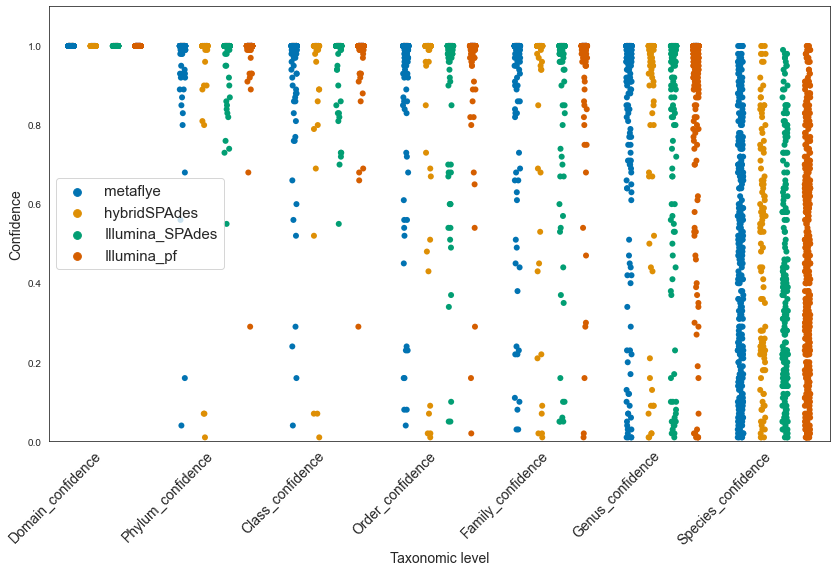

In [48]:
plt.figure(figsize=(14,8))
sns.set_style("white")
#grped_vplot = sns.violinplot(data=df_all, x="variable", y="value", hue="Source", 
            # palette="colorblind", scale='width')
scat_plot = sns.stripplot(data=df_all, x="variable", y="value", hue="Source",
                             color="k", dodge=True, palette="colorblind", size=6)
#plt.title("Assembly metrics by program")
plt.ylabel("Confidence", size=14)
plt.xlabel("Taxonomic level", size=14)
plt.xticks(rotation=45, ha='right', size=14)
plt.ylim(0, 1.1)

# Let us first get legend information from the plot object
#handles, labels = scat_plot.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:4], labels[0:4], prop={'size': 15})
#plt.gca().get_legend().remove()

#plt.savefig("SSU_taxonomy_confidences_scatter_nolegend.svg", format='svg', dpi=1200, bbox_inches='tight')
plt.show()

## Run one-way ANOVA to test for significant differences

In [3]:
import scipy.stats as stats

### Function to prepare data for stats test

In [4]:
def format_vsearch_stats(vs, source):
    taxa = vs[['hit']].copy()
    taxa[['Domain','Phylum','Class','Order','Family','Genus','Species']] = taxa['hit'].str.split(",", n=7, expand=True)
    taxa = taxa[taxa['Domain'].str.contains('None')==False] # filter out sequences with no assignment
    taxa = taxa.replace("\(NOR5\)", "-NOR5", regex=True)
    taxa = taxa.replace("\(Marine_group_B\)", "-Marine_Group_B", regex=True)
    taxa = taxa.replace("\(SAR406_clade\)", "-SAR406_clade", regex=True)
    taxa[['Domain','Domain_confidence']] = taxa['Domain'].str.split("(", n=2, expand=True, regex=False)
    taxa['Domain_confidence'] = taxa['Domain_confidence'].str.replace(")", "", regex=True)
    taxa[['Phylum','Phylum_confidence']] = taxa['Phylum'].str.split("(", n=2, expand=True, regex=False)
    taxa['Phylum_confidence'] = taxa['Phylum_confidence'].str.replace(")", "", regex=True)
    taxa[['Class','Class_confidence']] = taxa['Class'].str.split("(", n=2, expand=True, regex=False)
    taxa['Class_confidence'] = taxa['Class_confidence'].str.replace(")", "", regex=True)
    taxa[['Order','Order_confidence']] = taxa['Order'].str.split("(", n=2, expand=True, regex=False)
    taxa['Order_confidence'] = taxa['Order_confidence'].str.replace(")", "", regex=True)
    taxa[['Family','Family_confidence']] = taxa['Family'].str.split("(", n=2, expand=True, regex=False)
    taxa['Family_confidence'] = taxa['Family_confidence'].str.replace(")", "", regex=True)
    taxa[['Genus','Genus_confidence']] = taxa['Genus'].str.split("(", n=2, expand=True, regex=False)
    taxa['Genus_confidence'] = taxa['Genus_confidence'].str.replace(")", "", regex=True)
    taxa[['Species','Species_confidence']] = taxa['Species'].str.split("(", n=2, expand=True, regex=False)
    taxa['Species_confidence'] = taxa['Species_confidence'].str.replace(")", "", regex=True)
    taxa = taxa[['Domain_confidence','Phylum_confidence','Class_confidence','Order_confidence','Family_confidence',
             'Genus_confidence','Species_confidence']]
    taxa = taxa.astype(float)
    taxa = taxa.rename({'hit': source})
    taxa = taxa.add_prefix('%s_' % source)
    taxa = taxa.reset_index().drop(columns='index')
    return(taxa)

In [5]:
df=[]

for tsv in glob.glob("*.tsv"):
    a, b, c, d, e, f = tsv.split('-')
    vsearch = pd.read_csv(tsv, sep=" |\t", header=None, names=['query', 'hit','strand'], engine='python')
    vsearch_formatted = format_vsearch_stats(vsearch, a)
    df.append(vsearch_formatted)
    
df_all = pd.concat(df, axis=1, join="inner")

In [6]:
df_all.head()

,Illumina_SPAdes_Domain_confidence,Illumina_SPAdes_Phylum_confidence,Illumina_SPAdes_Class_confidence,Illumina_SPAdes_Order_confidence,Illumina_SPAdes_Family_confidence,Illumina_SPAdes_Genus_confidence,Illumina_SPAdes_Species_confidence,hybridSPAdes_Domain_confidence,hybridSPAdes_Phylum_confidence,hybridSPAdes_Class_confidence,...,metaflye_Family_confidence,metaflye_Genus_confidence,metaflye_Species_confidence,Illumina_pf_Domain_confidence,Illumina_pf_Phylum_confidence,Illumina_pf_Class_confidence,Illumina_pf_Order_confidence,Illumina_pf_Family_confidence,Illumina_pf_Genus_confidence,Illumina_pf_Species_confidence
0,1.0,1.0,1.0,1.00,1.00,0.97,0.07,1.0,1.0,1.00,...,1.0,1.0,0.51,1.0,1.0,1.0,1.00,1.00,1.00,1.00
1,1.0,1.0,1.0,1.00,1.00,1.00,0.16,1.0,1.0,1.00,...,1.0,1.0,1.00,1.0,1.0,1.0,0.98,0.98,0.98,0.91
2,1.0,1.0,1.0,1.00,1.00,1.00,0.31,1.0,0.9,0.89,...,1.0,1.0,0.77,1.0,1.0,1.0,1.00,1.00,1.00,0.96
3,1.0,1.0,1.0,1.00,1.00,1.00,0.22,1.0,1.0,1.00,...,1.0,1.0,0.31,1.0,1.0,1.0,1.00,1.00,1.00,0.99
4,1.0,1.0,1.0,0.98,0.98,0.98,0.39,1.0,1.0,1.00,...,1.0,1.0,0.90,1.0,1.0,1.0,1.00,1.00,1.00,0.46


In [34]:
df_level = df_all.filter(regex='Species')
print(list(df_level.columns))

['Illumina_SPAdes_Species_confidence', 'hybridSPAdes_Species_confidence', 'metaflye_Species_confidence', 'Illumina_pf_Species_confidence']


## Run ANOVA to test for differences

In [35]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df_level.loc[:, df_level.columns.str.match('^Illumina_SPAdes')], 
                                df_level.loc[:, df_level.columns.str.match('^Illumina_pf')], 
                                df_level.loc[:, df_level.columns.str.match('^hybridSPAdes')], 
                                df_level.loc[:, df_level.columns.str.match('^metaflye')])
print(fvalue, pvalue)

[2.16578938] [0.09132432]


#### We know that group values are statistically significantly different, but ANOVA does not tell which groups are significantly different from which other groups. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test.

In [20]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test

In [36]:
df_melt = pd.melt(df_level.reset_index(), id_vars=['index'], value_vars=list(df_level))
df_melt.head()

,index,variable,value
0,0,Illumina_SPAdes_Species_confidence,0.07
1,1,Illumina_SPAdes_Species_confidence,0.16
2,2,Illumina_SPAdes_Species_confidence,0.31
3,3,Illumina_SPAdes_Species_confidence,0.22
4,4,Illumina_SPAdes_Species_confidence,0.39


In [37]:
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='variable', anova_model='value ~ C(variable)')
res.tukey_summary

/Users/nastassia.patin/miniconda3/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Illumina_SPAdes_Species_confidence,hybridSPAdes_Species_confidence,0.090439,-0.010003,0.190880,3.283618,0.094514
1,Illumina_SPAdes_Species_confidence,metaflye_Species_confidence,0.071930,-0.028512,0.172371,2.611607,0.252981
2,Illumina_SPAdes_Species_confidence,Illumina_pf_Species_confidence,0.032105,-0.068336,0.132547,1.165669,0.822678
3,hybridSPAdes_Species_confidence,metaflye_Species_confidence,0.018509,-0.081933,0.118950,0.672011,0.900000
4,hybridSPAdes_Species_confidence,Illumina_pf_Species_confidence,0.058333,-0.042108,0.158775,2.117950,0.441209
5,metaflye_Species_confidence,Illumina_pf_Species_confidence,0.039825,-0.060617,0.140266,1.445939,0.711566


In [ ]:
# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

In [38]:
res.tukey_summary.to_csv("Species_differences_HSD.csv", index=None)